Grzegorz Słowiński
# Wykrywanie oszustw na kartach kredytowych

In [1]:
# wykonanie potrzebnych importów
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import potrzebnych funkcji z sci-kit learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

# import przeróżnych klasyfikatorów
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# do zapisywania i ładowania wyuczonych modeli
from joblib import dump, load

Pobranie danych dotyczących card kredytowych do pandas DataFrame cards.  
Plik powinien być umieszczony w tym samym katalogu, co notatnik   
Plik można pobrać np. tutaj https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
cards = pd.read_csv('creditcard.csv')

# podejrzenie charakterystyki zbioru card
cardsDescription = round(cards.describe(),2)
cardsDescription
#opcjonalne pobranie charakterystyki do pliku excel (odkomentuj linię poniżej)
#cardsDescription.to_excel("cardsDescription.xlsx") 


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Widać, że metryka TIME to sekundy od początku pomiaru - postanawiam wykonać modulo 86400, 
gdyż uważam, że większy pożytek da nam informacja w jakim momencie doby odbywa się transakcja

In [3]:
cards['Time'] = cards['Time']%86400

In [4]:
# obliczenie ilości oszustw
#oszustwa = sum (cards['Class']==1) - gorszy styl
oszustwa = cards[cards['Class']==1]['Class'].count()
transakcje = cards['Class'].count()
print ('Liczba oszustw to ',oszustwa)
print ('Oszustwa stanowią ',oszustwa/transakcje*100,"%")

Liczba oszustw to  492
Oszustwa stanowią  0.1727485630620034 %


## Wizualizacja
Spróbujemy zwizualizować punkty
Wizualizacja wymaga sprowadzenia punktów z 30 wymiarów do 2 wymiarów. Dokonujemy kolejnej transformacji PCA. Tworzymy kopię danych. Podstawowa analiza nastąpi na danych o 30 wymiarach

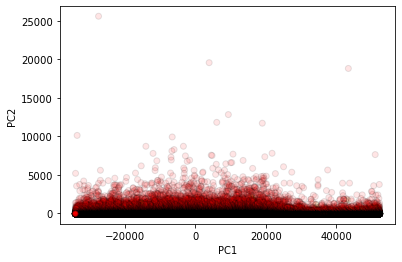

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cards2D= pca.fit_transform(cards)

# wykonanie wykresu
plt.scatter(cards2D[:, 0], cards2D[:, 1],c=cards['Class'], cmap=plt.cm.prism, edgecolor='k', alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.savefig('PC_Full.jpg')
plt.show()

Ze względu na ekstremalne niezbalansowanie danych nie widać punktów dla oszustw. Wydobędziemy klasę oszustw na odrębny wykres.

In [6]:
cardsCheats2D=np.empty([1,2])
for i in range(len(cards['Class'])):
        if (cards['Class'][i]==1):
            cardsCheats2D=np.append(cardsCheats2D,[cards2D[i]],axis=0)

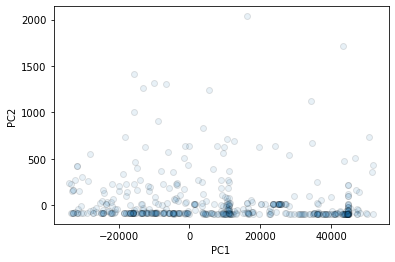

In [7]:
plt.scatter(cardsCheats2D[:, 0], cardsCheats2D[:, 1], cmap=plt.cm.prism, edgecolor='k', alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('PC_Cheats.jpg')
plt.show()

## Podział na dane treningowe i testowe

In [4]:
#Podział na zbiór cech Xcards i kolumnę oznaczeń klasy Ycards
Xcards=cards.drop('Class',axis=1)
Ycards=cards["Class"]

# Podział na zbiór treningowy i testowy. 
# random_state=5 is użyte, aby zapewnić powtarzalność
Xtrain,Xtest,Ytrain,Ytest=train_test_split(Xcards,Ycards,test_size=0.2, random_state=5)


## Wstępne analizy

### Gaussian Naive Bayes

In [9]:
model=GaussianNB()
model.fit(Xtrain,Ytrain)
Ypred=model.predict(Xtest)

print ('Wyniki klasyfikatora gaussian naive bayes')
print ('Trafność = ', round(accuracy_score(Ytest,Ypred)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,Ypred)*100,2),'%') 
print('Czułość = ', round(recall_score(Ytest,Ypred)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,Ypred,adjusted=True)*100,2),'%')

Wyniki klasyfikatora gaussian naive bayes
Trafność =  98.6 %
Precyzja =  9.73 %
Czułość =  80.77 %
Zbalansowana trafność = 79.4 %


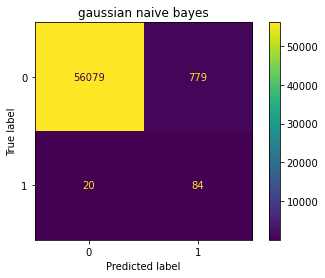

In [10]:
mat = confusion_matrix(Ytest, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=mat)

disp.plot()
plt.title("gaussian naive bayes")
plt.savefig('RF_C_matrix.png')
plt.show()

In [11]:
dtModelBig=DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30,random_state=1)
dtModelBig.fit(Xtrain,Ytrain)  # repated a few times to measure execution time
Ypred=dtModelBig.predict(Xtest)
print ('Wyniki klasyfikatora drzewo decyzyjne')
print ('Trafność = ', round(accuracy_score(Ytest,Ypred)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,Ypred)*100,2),'%') 
print('Czułość = ', round(recall_score(Ytest,Ypred)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,Ypred,adjusted=True)*100,2),'%')
print ("Pomijamy macierz pomyłki")

Wyniki klasyfikatora drzewo decyzyjne
Trafność =  99.95 %
Precyzja =  94.05 %
Czułość =  75.96 %
Zbalansowana trafność = 75.95 %
Pomijamy macierz pomyłki


In [12]:
lr=LogisticRegression(max_iter=1000) # zwiększ max iter do 10 000
lr.fit(Xtrain,Ytrain)  
Ypred=lr.predict(Xtest)
print ('Wyniki klasyfikatora regresja logistyczna')
print ('Trafność = ', round(accuracy_score(Ytest,Ypred)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,Ypred)*100,2),'%') 
print('Czułość = ', round(recall_score(Ytest,Ypred)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,Ypred,adjusted=True)*100,2),'%')
print ("Pomijamy macierz pomyłki")

Wyniki klasyfikatora regresja logistyczna
Trafność =  99.92 %
Precyzja =  84.34 %
Czułość =  67.31 %
Zbalansowana trafność = 67.28 %
Pomijamy macierz pomyłki


C:\Users\Grzegorz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
mSVC=SVC(kernel='poly',random_state=5) # jak dasz parametr C =100 lub więcej nie doczekasz się na wynik.
mSVC.fit(Xtrain,Ytrain)
Ypred=mSVC.predict(Xtest)
print ('Wyniki klasyfikatora maszyna wektorów nośnych')
print ('Trafność = ', round(accuracy_score(Ytest,Ypred)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,Ypred)*100,2),'%') 
print('Czułość = ', round(recall_score(Ytest,Ypred)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,Ypred,adjusted=True)*100,2),'%')
print ("Pomijamy macierz pomyłki")

Wyniki klasyfikatora maszyna wektorów nośnych
Trafność =  99.82 %
Precyzja =  0.0 %
Czułość =  0.0 %
Zbalansowana trafność = 0.0 %
Pomijamy macierz pomyłki


C:\Users\Grzegorz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# ten model nie jest w stanie się nic nauczyć. Czułość 0.
sgdModel = SGDClassifier(random_state=5)
sgdModel.fit(Xtrain,Ytrain)
Ypred=sgdModel.predict(Xtest)
print ('Wyniki klasyfikatora SGD')
print ('Trafność = ', round(accuracy_score(Ytest,Ypred)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,Ypred)*100,2),'%') 
print('Czułość = ', round(recall_score(Ytest,Ypred)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,Ypred,adjusted=True)*100,2),'%')
print ("Pomijamy macierz pomyłki")

Wyniki klasyfikatora SGD
Trafność =  99.81 %
Precyzja =  0.0 %
Czułość =  0.0 %
Zbalansowana trafność = -0.01 %
Pomijamy macierz pomyłki


### Wstępna analiza prostą siecią neuronową
Niestety sieć nie jest w stanie się nauczyć. Można pominąć

In [9]:
# import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
#from keras.layers.normalization import BatchNormalization
from keras import backend
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

from sklearn.preprocessing import StandardScaler,  LabelEncoder

In [10]:
# Przeskalowanie (normalizacja) danych. Konieczna dla sieci neuronowej.
sc = StandardScaler()
XtrainS = sc.fit_transform(Xtrain) # średnią i std wyliczam na podstawie tego zbioru
XtestS = sc.transform(Xtest) # używam średniej i std wyliczonej dla Xtrain

In [11]:
# Budowa kilkuwarstwowej sieci
ANN=Sequential()
ANN.add(Dense(60,input_dim=30,activation = 'relu'))

# Bulding Second and third layer
ANN.add(Dense(30,activation='relu'))
ANN.add(Dense(30,activation='relu'))

# Output Layer
ANN.add(Dense(1,activation='softmax'))

ANN.compile(optimizer='Adam',loss='binary_crossentropy')

In [12]:
# krótkie uczenie - przebieg uczenia zapisany do obiektu hist
hist=ANN.fit(XtrainS,Ytrain,epochs=6,batch_size=32,validation_split=0.1)

Epoch 1/6
6409/6409 [==============================] - 3s 505us/step - loss: 15.2237 - val_loss: 15.2243
Epoch 2/6
6409/6409 [==============================] - 3s 486us/step - loss: 15.2237 - val_loss: 15.2243
Epoch 3/6
6409/6409 [==============================] - 3s 502us/step - loss: 15.2237 - val_loss: 15.2243
Epoch 4/6
6409/6409 [==============================] - 3s 504us/step - loss: 15.2237 - val_loss: 15.2243
Epoch 5/6
6409/6409 [==============================] - 3s 507us/step - loss: 15.2237 - val_loss: 15.2243
Epoch 6/6
6409/6409 [==============================] - 3s 503us/step - loss: 15.2237 - val_loss: 15.2243


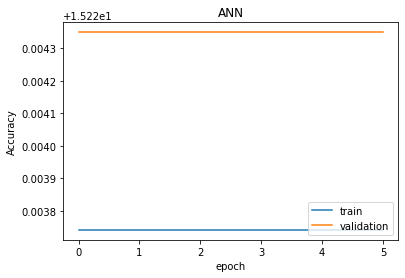

In [13]:
#wizualizacja procesu uczenia sieci

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('ANN')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [14]:
YpredKatFF=ANN.predict(XtestS) # przewidywanie przez sieć
YpredFF= np.argmax(YpredKatFF,axis=1) # przejście z danych "kategorycznych" na konkretne cyfry

In [15]:
print ('Wyniki klasyfikatora ANN')
print ('Trafność = ', round(accuracy_score(Ytest,YpredFF)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,YpredFF)*100,2),'%') 
print('Czułość = ', round(recall_score(Ytest,YpredFF)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,YpredFF,adjusted=True)*100,2),'%')
print ("Pomijamy macierz pomyłki")

Wyniki klasyfikatora ANN
Trafność =  99.82 %
Precyzja =  0.0 %
Czułość =  0.0 %
Zbalansowana trafność = 0.0 %
Pomijamy macierz pomyłki


C:\Users\Grzegorz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Przechodzimy do analizy modelem Lasu Losowego  
Las sobie radzi najlepiej, dlatego się na nim skupiam

In [16]:
# import potrzebnych funkcji z sci-kit learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load


In [5]:
# Podział na atrybuty i znacznik klasy
Xcards=cards.drop('Class',axis=1)
Ycards=cards["Class"]

# Podział na zbiór treningowy i testowy,  random_state=5 zapewnia powtarzalność
Xtrain,Xtest,Ytrain,Ytest=train_test_split(Xcards,Ycards, test_size=0.2, random_state=5)


In [19]:
#rndForest = RandomForestClassifier(n_estimators=150,n_jobs=-1, random_state=1)
#rndForest.fit(Xtrain,Ytrain)
#zapisanie modelu w celu ponownego użycia (następnym razem nie trzeba ponownie uczyć)
#dump(rndForest, 'rndForest.joblib')

#Po pierwszym treningu i zapisaniu wystarczy model "wgrać"

rndForest=load('rndForest.joblib')

In [20]:
Ypred=rndForest.predict(Xtest)

print ('Trafność = ', round(accuracy_score(Ytest,Ypred)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,Ypred)*100,2),'%') 
print('Wypełnienie (recall) = ', round(recall_score(Ytest,Ypred)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,Ypred,adjusted=True)*100,2),'%')

Trafność =  99.96 %
Precyzja =  97.65 %
Wypełnienie (recall) =  79.81 %
Zbalansowana trafność = 79.8 %


In [17]:
# taki teścik ile trwa predykcja.
%timeit Ypred=rndForest.predict(Xtest)

189 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print ('Sprawdzenie pojedynczej próbki trwa około ',189000/56800,' mikrosekund')

Sprawdzenie pojedynczej próbki trwa około  3.3274647887323945  mikrosekund


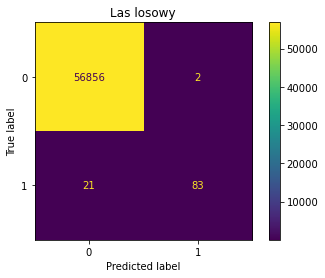

In [21]:
mat = confusion_matrix(Ytest, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=mat)

disp.plot()
plt.title("Las losowy")
plt.savefig('RF_C_matrix.png')
plt.show()

#### Sprawdzenie jak sobie LL poradzi na danych treningowych

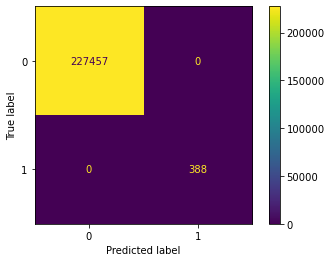

In [22]:
YpredTrain=rndForest.predict(Xtrain)
mat = confusion_matrix(Ytrain, YpredTrain)
#cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()

#### Fakt, że na danych treningowych wychodzi perfekt oznacza prawdopodobnie, że utworzony las ulega przeuczeniu
Trzeba by się temu dokładiej przyjrzeć, wykonać jakąś optymalizację hiperparametrów modelu

### Badanie testem krzyżowym lasu losowego

In [58]:
from sklearn.model_selection import cross_validate

scores = cross_validate (rndForest, Xcards,Ycards,scoring=("precision","recall"), cv=5)

In [59]:
scores

{'fit_time': array([63.64752412, 62.75530124, 76.45073152, 75.48900342, 73.19011426]),
 'score_time': array([0.20329618, 0.19824958, 0.19665074, 0.20580745, 0.20162463]),
 'test_precision': array([0.68503937, 0.9875    , 0.80487805, 0.97530864, 0.98571429]),
 'test_recall': array([0.87878788, 0.7979798 , 0.67346939, 0.80612245, 0.70408163])}

### Wykonanie wykresów Precyzji i Czułości względem progu prawdopodobieństwa

In [24]:
probabilities=rndForest.predict_proba(Xtest)

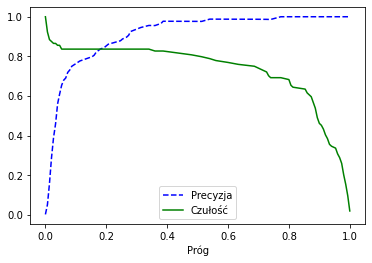

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(Ytest,probabilities[:,1] )

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja")
    plt.plot(thresholds, recalls[:-1], "g-", label="Czułość")
    plt.legend()
    plt.xlabel('Próg')
#[...] # highlight the threshold, add the legend, axis label and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.savefig('Prec_Recall_Thres.png')
plt.show()

### Wykonanie wykresu Precyzji vs Czułość

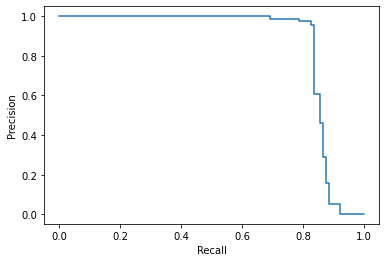

In [28]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(Ytest, probabilities[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.savefig('PrecvsRecall.png')
plt.show()

## Wstępne balansowanie danych

In [30]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler # pobranie Oversamplera
over_sampler = RandomOverSampler(random_state=42)
XtrainOv, YtrainOv = over_sampler.fit_resample(Xtrain, Ytrain)
print(f"Training target statistics: {Counter(YtrainOv)}")
print(f"Testing target statistics: {Counter(Ytest)}")

Training target statistics: Counter({0: 227457, 1: 227457})
Testing target statistics: Counter({0: 56858, 1: 104})


In [34]:
#rndForestOv = RandomForestClassifier(n_estimators=150,n_jobs=-1, random_state=1)
#rndForestOv.fit(XtrainOv,YtrainOv)
#zapisanie modelu w celu ponownego użycia (następnym razem nie trzeba ponownie uczyć)
#dump(rndForestOv, 'rndForestOv.joblib')

#Po pierwszym treningu i zapisaniu wystarczy model "wgrać"

rndForestOv=load('rndForestOv.joblib')

In [35]:
Ypred=rndForestOv.predict(Xtest)

print ('Trafność = ', round(accuracy_score(Ytest,Ypred)*100,2),'%')
print('Precyzja = ',round(precision_score(Ytest,Ypred)*100,2),'%') 
print('Wypełnienie (recall) = ', round(recall_score(Ytest,Ypred)*100,2),'%') 
print('Zbalansowana trafność =', round(balanced_accuracy_score(Ytest,Ypred,adjusted=True)*100,2),'%')

Trafność =  99.96 %
Precyzja =  98.82 %
Wypełnienie (recall) =  80.77 %
Zbalansowana trafność = 80.77 %


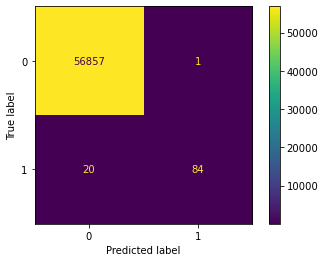

In [36]:
mat = confusion_matrix(Ytest, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.savefig('RF_C_matrixOV.png')
plt.show()


### Widać, że udało się poprawić o 1 próbkę czułość. Mało, ale zawsze coś. Trzeba by to dokładniej zbadać